In [196]:
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import classification_report,f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression

Scenario: EcomX Retailers is a mid-sized online retail company specializing in electronics, clothing, and home goods. The company has been growing steadily over the past few years and wants to optimize its marketing and customer retention strategies. One key aspect of this strategy is to understand the Customer Lifetime Value (CLV) of its customers. By predicting the CLV, EcomX aims to identify high-value customers and tailor personalized marketing efforts to retain them, while also identifying low-value customers to manage resources effectively.

Objective: The objective of this assignment is to build and evaluate a machine learning model to predict the Customer Lifetime Value (CLV) of EcomX’s customers. You will need to identify and apply various data cleaning and preparation techniques, as well as select an appropriate model and evaluation criteria.

In [131]:
customer = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

Data Cleaning (Missing Values)

In [132]:
customer.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [133]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [134]:
customer.describe()

,customer_id,age
count,10000.00000,8991.000000
mean,5000.50000,43.467467
std,2886.89568,15.094380
min,1.00000,18.000000
25%,2500.75000,30.000000
50%,5000.50000,44.000000
75%,7500.25000,57.000000
max,10000.00000,69.000000


In [135]:
#fill out missing value to customer's age column with the age mean
customer['age']= customer['age'].fillna(customer['age'].mean())

In [136]:
#change the data type from float to int
customer['age']= customer['age'].astype(int)

In [137]:
#check if missing values are gone
customer.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,43,Male,Hillville
2,3,2021-06-01,2022-11-27,43,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29,Male,Grossstad
4,5,2022-01-24,2023-06-02,43,Male,East Matthewfort


In [138]:
#fill out missing data under gender column
#N/A is defined as Other
def gender_type(x):
    if x == 'Female':
        return 'Female'
    elif x == 'Male':
        return 'Male'
    else:
        return 'Other'

customer['gender'] = customer['gender'].apply(gender_type)

In [139]:
#check if all missing data are gone
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         10000 non-null  int64 
 1   join_date           10000 non-null  object
 2   last_purchase_date  10000 non-null  object
 3   age                 10000 non-null  int32 
 4   gender              10000 non-null  object
 5   location            10000 non-null  object
dtypes: int32(1), int64(1), object(4)
memory usage: 429.8+ KB


In [140]:
engagement.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [141]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [142]:
engagement.describe()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,100.111900,39.862100,19.725300
std,2886.89568,118.625052,46.511719,22.975083
min,1.00000,1.000000,1.000000,1.000000
25%,2500.75000,15.000000,6.000000,3.000000
50%,5000.50000,53.000000,22.000000,11.000000
75%,7500.25000,141.000000,57.000000,28.000000
max,10000.00000,711.000000,303.000000,142.000000


In [143]:
#investigat if there exist outlier
engagement[engagement['number_of_site_visits'] == 711]

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
4052,4053,711,17,1


In [144]:
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [145]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [146]:
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [147]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


In [148]:
customer['join_date'] = pd.to_datetime(customer['join_date'])
customer['last_purchase_date'] = pd.to_datetime(customer['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

Join Tables

In [149]:
# split at customer level with # of marketing campaigns customer responded YES and No
# step 1: marketing data at a customer level

marketing_agg_yes = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()
marketing_agg_no = marketing[marketing['response']=='No'].groupby('customer_id')['campaign_id'].count().to_frame()

In [150]:
# step 2: aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [151]:
# step 3: set customers and engagement index as customer_id
customer.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [152]:
# step 4: join all tables
joint_data_yes = customer.join(engagement).join(transactions_agg).join(marketing_agg_yes)
joint_data_no = customer.join(engagement).join(transactions_agg).join(marketing_agg_no)

In [153]:
# now have a customer level data set;  you will see some NaN values under campaign_id because some customers haven't been targeted with any marketing campaigns
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,43,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,43,Other,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,43,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39,Male,New John,53,17,5,3,3503.13,1.0


In [154]:
joint_data_yes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   join_date                10000 non-null  datetime64[ns]
 1   last_purchase_date       10000 non-null  datetime64[ns]
 2   age                      10000 non-null  int32         
 3   gender                   10000 non-null  object        
 4   location                 10000 non-null  object        
 5   number_of_site_visits    10000 non-null  int64         
 6   number_of_emails_opened  10000 non-null  int64         
 7   number_of_clicks         10000 non-null  int64         
 8   transaction_id           10000 non-null  int64         
 9   transaction_amount       10000 non-null  float64       
 10  campaign_id              7665 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int32(1), int64(4), object(2)
memory usage: 1.1+ MB


In [155]:
#set missing campaign id as 0 to mark the customer who are not target for campaign
joint_data_yes['campaign_id']= joint_data_yes['campaign_id'].fillna(0)
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,43,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,43,Other,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,43,Male,East Matthewfort,161,2,7,24,15524.55,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,Female,Johnstonborough,119,47,16,10,5498.20,0.0
9997,2022-07-09,2023-01-25,26,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39,Male,New John,53,17,5,3,3503.13,1.0


In [156]:
joint_data_no

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,Female,North Shannonbury,10,15,1,6,3509.48,3.0
2,2021-09-08,2023-10-25,43,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,43,Other,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29,Male,Grossstad,110,30,17,20,7874.68,3.0
5,2022-01-24,2023-06-02,43,Male,East Matthewfort,161,2,7,24,15524.55,4.0
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,Female,Johnstonborough,119,47,16,10,5498.20,3.0
9997,2022-07-09,2023-01-25,26,Male,Jessicamouth,3,33,14,12,5848.30,NaN
9998,2023-09-17,2024-01-30,39,Male,New John,53,17,5,3,3503.13,NaN


Feature engineering

<Axes: xlabel='transaction_amount', ylabel='Count'>

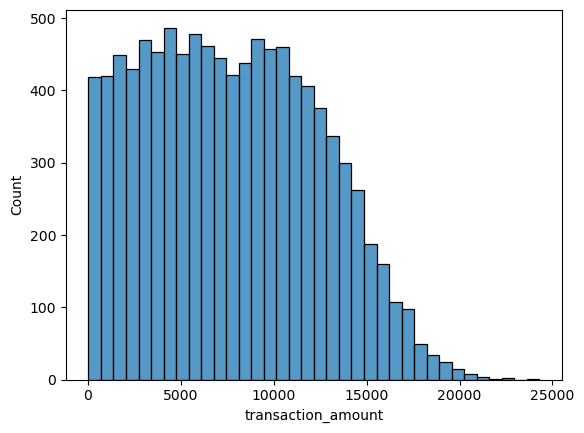

In [157]:
sns.histplot(joint_data_yes['transaction_amount'])

In [158]:
#create a new column named 'average_purchase_value'
joint_data_yes['avg_purchase_per_transaction'] = joint_data_yes['transaction_amount']/joint_data_yes['transaction_id']
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,avg_purchase_per_transaction
customer_id,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,Female,North Shannonbury,10,15,1,6,3509.48,1.0,584.913333
2,2021-09-08,2023-10-25,43,Male,Hillville,285,49,51,9,6081.32,2.0,675.702222
3,2021-06-01,2022-11-27,43,Other,North Latoyatown,192,73,25,6,1454.87,1.0,242.478333
4,2022-01-01,2022-09-01,29,Male,Grossstad,110,30,17,20,7874.68,1.0,393.734000
5,2022-01-24,2023-06-02,43,Male,East Matthewfort,161,2,7,24,15524.55,0.0,646.856250
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,Female,Johnstonborough,119,47,16,10,5498.20,0.0,549.820000
9997,2022-07-09,2023-01-25,26,Male,Jessicamouth,3,33,14,12,5848.30,1.0,487.358333
9998,2023-09-17,2024-01-30,39,Male,New John,53,17,5,3,3503.13,1.0,1167.710000


In [159]:

#create column 'customer_lifespan' in years
joint_data_yes['customer_lifetime'] = joint_data_yes['last_purchase_date'] - joint_data_yes['join_date']
joint_data_yes['customer_lifetime'] = joint_data_yes['customer_lifetime']/pd.Timedelta('365 days')
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,avg_purchase_per_transaction,customer_lifetime
customer_id,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,Female,North Shannonbury,10,15,1,6,3509.48,1.0,584.913333,0.323288
2,2021-09-08,2023-10-25,43,Male,Hillville,285,49,51,9,6081.32,2.0,675.702222,2.128767
3,2021-06-01,2022-11-27,43,Other,North Latoyatown,192,73,25,6,1454.87,1.0,242.478333,1.490411
4,2022-01-01,2022-09-01,29,Male,Grossstad,110,30,17,20,7874.68,1.0,393.734000,0.665753
5,2022-01-24,2023-06-02,43,Male,East Matthewfort,161,2,7,24,15524.55,0.0,646.856250,1.353425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,Female,Johnstonborough,119,47,16,10,5498.20,0.0,549.820000,0.657534
9997,2022-07-09,2023-01-25,26,Male,Jessicamouth,3,33,14,12,5848.30,1.0,487.358333,0.547945
9998,2023-09-17,2024-01-30,39,Male,New John,53,17,5,3,3503.13,1.0,1167.710000,0.369863


<Axes: xlabel='customer_lifetime', ylabel='Count'>

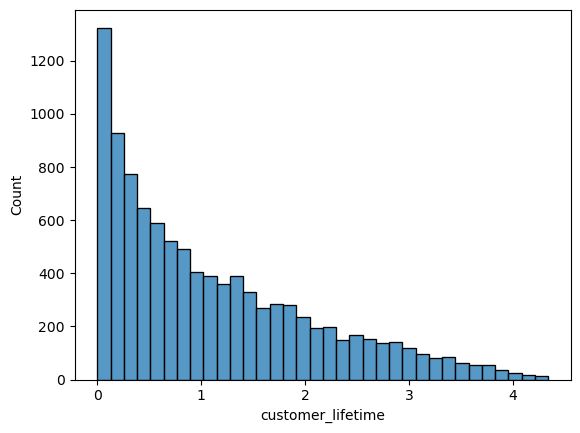

In [160]:
sns.histplot(joint_data_yes['customer_lifetime'])

In [161]:
#as the customer staying longer with the company, they have the chance to have higher transactions
#so I classify the customer_lifetime based on the mean()
joint_data_yes['customer_lifetime'].mean()

1.1023934246575344

In [162]:
joint_data_yes['binary_output'] = joint_data_yes['customer_lifetime'].apply(lambda x: 1 if x>=1.1 else 0)

In [163]:
joint_data_yes.groupby('binary_output')['customer_lifetime'].count()

binary_output
0    5915
1    4085
Name: customer_lifetime, dtype: int64

In [164]:
from sklearn.preprocessing import StandardScaler,LabelEncoder

#label encode categorical data
le = LabelEncoder()
joint_data_yes['gender']=le.fit_transform(joint_data_yes['gender'])
joint_data_yes['location']=le.fit_transform(joint_data_yes['location'])
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,avg_purchase_per_transaction,customer_lifetime,binary_output
customer_id,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,0,4747,10,15,1,6,3509.48,1.0,584.913333,0.323288,0
2,2021-09-08,2023-10-25,43,1,2074,285,49,51,9,6081.32,2.0,675.702222,2.128767,1
3,2021-06-01,2022-11-27,43,2,4613,192,73,25,6,1454.87,1.0,242.478333,1.490411,1
4,2022-01-01,2022-09-01,29,1,1916,110,30,17,20,7874.68,1.0,393.734000,0.665753,0
5,2022-01-24,2023-06-02,43,1,1433,161,2,7,24,15524.55,0.0,646.856250,1.353425,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,0,2384,119,47,16,10,5498.20,0.0,549.820000,0.657534,0
9997,2022-07-09,2023-01-25,26,1,2315,3,33,14,12,5848.30,1.0,487.358333,0.547945,0
9998,2023-09-17,2024-01-30,39,1,4017,53,17,5,3,3503.13,1.0,1167.710000,0.369863,0


In [165]:
joint_data_yes.describe()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,avg_purchase_per_transaction,customer_lifetime,binary_output
count,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2022-03-19 09:28:13.439999744,2023-04-25 18:26:12.480000,43.420300,0.583500,3883.754200,100.111900,39.862100,19.725300,12.954500,7737.562981,1.257800,599.842451,1.102393,0.408500
min,2020-01-01 00:00:00,2020-01-26 00:00:00,18.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,23.810000,0.000000,23.810000,0.000000,0.000000
25%,2021-02-15 00:00:00,2022-09-19 00:00:00,32.000000,0.000000,2007.750000,15.000000,6.000000,3.000000,7.000000,3839.915000,1.000000,488.343409,0.295890,0.000000
50%,2022-03-19 00:00:00,2023-08-04 00:00:00,43.000000,1.000000,3886.500000,53.000000,22.000000,11.000000,13.000000,7498.890000,1.000000,587.587333,0.821918,0.000000
75%,2023-04-28 00:00:00,2024-02-11 00:00:00,55.000000,1.000000,5811.250000,141.000000,57.000000,28.000000,19.000000,11275.797500,2.000000,692.701750,1.693151,1.000000
max,2024-05-31 00:00:00,2024-05-31 00:00:00,69.000000,2.000000,7694.000000,711.000000,303.000000,142.000000,25.000000,24298.220000,4.000000,1997.080000,4.336986,1.000000
std,NaN,NaN,14.313236,0.591323,2214.035304,118.625052,46.511719,22.975083,7.191203,4628.799469,0.971511,197.350557,0.974601,0.491581


In [166]:
#Customer Lifetime Value = (transaction sum * Customer Lifespan)
#creating lifetime value per year per customer
joint_data_yes['customer_lifetime_value'] = (joint_data_yes['transaction_amount']*joint_data_yes['customer_lifetime']).round(1)

In [167]:
joint_data_yes.describe()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,avg_purchase_per_transaction,customer_lifetime,binary_output,customer_lifetime_value
count,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2022-03-19 09:28:13.439999744,2023-04-25 18:26:12.480000,43.420300,0.583500,3883.754200,100.111900,39.862100,19.725300,12.954500,7737.562981,1.257800,599.842451,1.102393,0.408500,8479.794250
min,2020-01-01 00:00:00,2020-01-26 00:00:00,18.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,23.810000,0.000000,23.810000,0.000000,0.000000,0.000000
25%,2021-02-15 00:00:00,2022-09-19 00:00:00,32.000000,0.000000,2007.750000,15.000000,6.000000,3.000000,7.000000,3839.915000,1.000000,488.343409,0.295890,0.000000,1392.000000
50%,2022-03-19 00:00:00,2023-08-04 00:00:00,43.000000,1.000000,3886.500000,53.000000,22.000000,11.000000,13.000000,7498.890000,1.000000,587.587333,0.821918,0.000000,4644.600000
75%,2023-04-28 00:00:00,2024-02-11 00:00:00,55.000000,1.000000,5811.250000,141.000000,57.000000,28.000000,19.000000,11275.797500,2.000000,692.701750,1.693151,1.000000,11994.000000
max,2024-05-31 00:00:00,2024-05-31 00:00:00,69.000000,2.000000,7694.000000,711.000000,303.000000,142.000000,25.000000,24298.220000,4.000000,1997.080000,4.336986,1.000000,76441.100000
std,NaN,NaN,14.313236,0.591323,2214.035304,118.625052,46.511719,22.975083,7.191203,4628.799469,0.971511,197.350557,0.974601,0.491581,10094.479366


Modeling - using binary output

In [169]:
train, test = train_test_split(joint_data_yes, test_size=0.3,random_state=1234)

In [170]:
features = ['age','gender','location','number_of_site_visits','number_of_emails_opened','number_of_clicks','campaign_id']

target = 'binary_output'

In [171]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [172]:
#cross validation - divide dataset to 5 sections, train 4 sections and test 1 section, repeat the process 5 times
#quickly create 5 models and pick the best one
scores = cross_val_score(LogisticRegression(), train[features], train[target], cv=5, scoring='accuracy')

c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

In [173]:
scores

array([0.89071429, 0.88928571, 0.86928571, 0.88285714, 0.895     ])

In [174]:
#calculate average score
np.mean(scores)

0.8854285714285715

In [175]:
#building an actual model
logreg = LogisticRegression().fit(train[features], train[target])

c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [176]:
logreg.coef_

array([[-5.04976092e-02, -3.28769063e-01, -1.81470470e-04,
         1.46444181e-02,  3.61028222e-02,  8.13359275e-02,
        -5.21440266e-01]])

In [177]:
test[features]

,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,campaign_id
customer_id,,,,,,,
2375,51,1,3339,2,1,1,1.0
1785,33,0,3459,5,13,3,2.0
6302,38,1,6204,17,12,5,1.0
1601,43,0,3748,113,46,9,0.0
7921,20,0,7161,32,24,1,0.0
...,...,...,...,...,...,...,...
1993,44,1,5691,387,4,73,0.0
6893,45,1,2063,93,45,5,1.0
2029,31,0,5393,187,69,25,2.0


In [178]:
y_pred=logreg.predict(test[features])
y_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [179]:
from sklearn.metrics import accuracy_score
accuracy_score(test[target],y_pred)

0.8816666666666667

In [180]:
precision_score(test[target], y_pred)

0.8718572587185726

In [181]:
recall_score(test[target],y_pred)

0.845125786163522

In [182]:
f1_score(test[target], y_pred)

0.8582834331337326

Modeling - using customer life time value

<Axes: xlabel='customer_lifetime_value', ylabel='Count'>

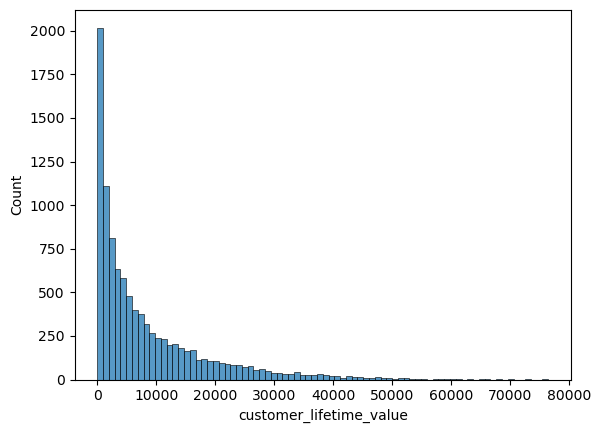

In [183]:
sns.histplot(joint_data_yes['customer_lifetime_value'])

In [184]:
joint_data_yes['customer_lifetime_value'].median()

4644.6

In [185]:
joint_data_yes

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,avg_purchase_per_transaction,customer_lifetime,binary_output,customer_lifetime_value
customer_id,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,0,4747,10,15,1,6,3509.48,1.0,584.913333,0.323288,0,1134.6
2,2021-09-08,2023-10-25,43,1,2074,285,49,51,9,6081.32,2.0,675.702222,2.128767,1,12945.7
3,2021-06-01,2022-11-27,43,2,4613,192,73,25,6,1454.87,1.0,242.478333,1.490411,1,2168.4
4,2022-01-01,2022-09-01,29,1,1916,110,30,17,20,7874.68,1.0,393.734000,0.665753,0,5242.6
5,2022-01-24,2023-06-02,43,1,1433,161,2,7,24,15524.55,0.0,646.856250,1.353425,1,21011.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42,0,2384,119,47,16,10,5498.20,0.0,549.820000,0.657534,0,3615.3
9997,2022-07-09,2023-01-25,26,1,2315,3,33,14,12,5848.30,1.0,487.358333,0.547945,0,3204.5
9998,2023-09-17,2024-01-30,39,1,4017,53,17,5,3,3503.13,1.0,1167.710000,0.369863,0,1295.7


In [215]:
from sklearn.preprocessing import MinMaxScaler
columns = joint_data_yes.drop(columns=['join_date','last_purchase_date'])
# Apply Min-Max Scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(columns)
scaled_features

array([[0.74509804, 0.        , 0.61697427, ..., 0.07454201, 0.        ,
        0.0148428 ],
       [0.49019608, 0.5       , 0.2695607 , ..., 0.49084018, 1.        ,
        0.16935523],
       [0.49019608, 1.        , 0.5995581 , ..., 0.3436513 , 1.        ,
        0.02836694],
       ...,
       [0.41176471, 0.5       , 0.52209514, ..., 0.08528111, 0.        ,
        0.01695031],
       [0.25490196, 0.        , 0.02053548, ..., 0.04169299, 0.        ,
        0.01590113],
       [0.96078431, 0.5       , 0.27216012, ..., 0.06190777, 0.        ,
        0.02028752]])

In [220]:
scaled_features_df = pd.DataFrame(scaled_features, columns=columns.columns)
scaled_features_df

,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,avg_purchase_per_transaction,customer_lifetime,binary_output,customer_lifetime_value
0,0.745098,0.0,0.616974,0.012676,0.046358,0.000000,0.208333,0.143594,0.25,0.284352,0.074542,0.0,0.014843
1,0.490196,0.5,0.269561,0.400000,0.158940,0.354610,0.333333,0.249543,0.50,0.330361,0.490840,1.0,0.169355
2,0.490196,1.0,0.599558,0.269014,0.238411,0.170213,0.208333,0.058953,0.25,0.110815,0.343651,1.0,0.028367
3,0.215686,0.5,0.249025,0.153521,0.096026,0.113475,0.791667,0.323422,0.25,0.187468,0.153506,0.0,0.068584
4,0.490196,0.5,0.186249,0.225352,0.003311,0.042553,0.958333,0.638563,0.00,0.315743,0.312066,1.0,0.274869
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.470588,0.0,0.309852,0.166197,0.152318,0.106383,0.375000,0.225521,0.00,0.266568,0.151611,0.0,0.047295
9996,0.156863,0.5,0.300884,0.002817,0.105960,0.092199,0.458333,0.239944,0.25,0.234914,0.126342,0.0,0.041921
9997,0.411765,0.5,0.522095,0.073239,0.052980,0.028369,0.083333,0.143333,0.25,0.579698,0.085281,0.0,0.016950
9998,0.254902,0.0,0.020535,0.030986,0.013245,0.021277,0.458333,0.275930,0.00,0.271805,0.041693,0.0,0.015901


In [230]:

# split data into X variables and y variable
# we are going to predict whether on any given hour, we will rent a HIGH number of bikes (1 = 357+ bikes) OR a LOW number of bikes (0 = <357 bikes)
X = scaled_features_df[['age','gender','location','number_of_site_visits','number_of_emails_opened','number_of_clicks','campaign_id']]
y = scaled_features_df['customer_lifetime_value']

In [231]:
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [232]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay

In [233]:
from sklearn.ensemble import RandomForestRegressor

In [238]:
# Model training
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
model = rf_model.fit(X_train, y_train)

In [239]:
# Model prediction
y_pred_rf = model.predict(X_test)
y_pred_rf = y_pred_rf.round(2)


In [240]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [241]:
# Evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Mean Absolute Error (MAE): {mae_rf}')
print(f'Mean Squared Error (MSE): {mse_rf}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf}')
print(f'R-squared (R²): {r2_rf}')

Mean Absolute Error (MAE): 0.06376673085988209
Mean Squared Error (MSE): 0.010001570814465482
Root Mean Squared Error (RMSE): 0.10000785376391938
R-squared (R²): 0.44165925739064205


In [242]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

In [243]:
print(f'Cross-Validated R² Scores: {cv_scores}')
print(f'Mean Cross-Validated R²: {np.mean(cv_scores)}')

Cross-Validated R² Scores: [0.44468992 0.44638706 0.44133742 0.4372958  0.45300477]
Mean Cross-Validated R²: 0.44454299176604123
